In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from tqdm import tqdm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('max_colwidth', 800)
from scipy import signal

/tmp/ipykernel_67118/335835994.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
data_dir = 'data_by_days'
NUM_TRAIN_FILES = 1

df = pd.concat([pd.read_feather(f'{data_dir}/train_{i}.feather') for i in tqdm(range(NUM_TRAIN_FILES))])
df.reset_index(drop=True, inplace=True)
df.head(5)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 42.36it/s]


,timestamp,target,MIRAMAR_bid0_price,MIRAMAR_bid0_qty,MIRAMAR_bid1_price,MIRAMAR_bid1_qty,MIRAMAR_bid2_price,MIRAMAR_bid2_qty,MIRAMAR_bid3_price,MIRAMAR_bid3_qty,...,LIVIK_ask0_price,LIVIK_ask0_qty,LIVIK_ask1_price,LIVIK_ask1_qty,LIVIK_ask2_price,LIVIK_ask2_qty,LIVIK_ask3_price,LIVIK_ask3_qty,LIVIK_ask4_price,LIVIK_ask4_qty
0,1970-01-01 02:00:00.000000000,-1.0,26788.0,6.0,26787.0,4.0,26783.0,11.0,26782.0,1.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0
1,1970-01-01 02:00:00.499097340,47.5,26788.0,6.0,26787.0,4.0,26783.0,11.0,26782.0,1.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0
2,1970-01-01 02:00:00.499100368,47.5,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0
3,1970-01-01 02:00:00.499143008,48.5,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0
4,1970-01-01 02:00:00.502273623,48.5,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0


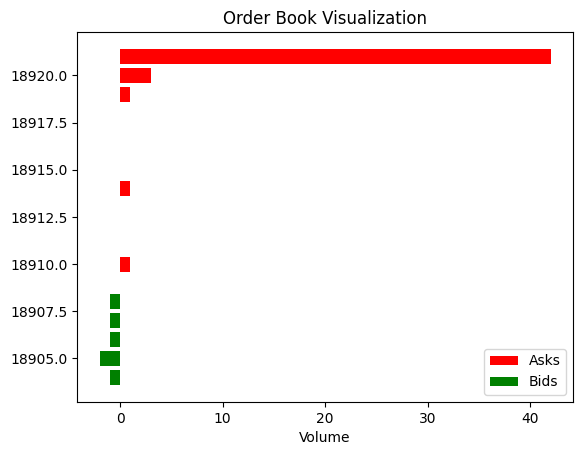

In [3]:
def draw_orderbook(df, number_of_snapshot, instrument='SANHOK'):
    ask_prices_columns = [column for column in df.columns if column.startswith(f'{instrument}_ask') and column.endswith('price')]
    bid_prices_columns = [column for column in df.columns if column.startswith(f'{instrument}_bid') and column.endswith('price')]
    ask_vol_columns = [column for column in df.columns if column.startswith(f'{instrument}_ask') and column.endswith('qty')]
    bid_vol_columns = [column for column in df.columns if column.startswith(f'{instrument}_bid') and column.endswith('qty')]
    assert number_of_snapshot < len(df)
    ask_prices = df.loc[number_of_snapshot, ask_prices_columns].values
    bid_prices = df.loc[number_of_snapshot, bid_prices_columns].values
    ask_volumes = df.loc[number_of_snapshot, ask_vol_columns].values
    bid_volumes = df.loc[number_of_snapshot, bid_vol_columns].values
    _, ax = plt.subplots()

    ax.barh(ask_prices, ask_volumes, color='red', label='Asks')
    
    ax.barh(bid_prices, -bid_volumes, color='green', label='Bids')

    ax.set_xlabel('Volume')
    ax.set_title('Order Book Visualization')

    ax.legend()
    plt.show()


draw_orderbook(df, 500)

In [4]:
@njit
def get_future_price(ts, values, window):
    price_pointer = 0
    res = np.zeros(ts.size)
    for X_pointer in range(len(ts)):
        while price_pointer + 1 < len(ts) and ts[price_pointer] < ts[X_pointer] + window:
            price_pointer += 1
        res[X_pointer] = values[price_pointer]
    return res

for i in tqdm(range(NUM_TRAIN_FILES)):
    day_df = pd.read_feather(f'{data_dir}/train_{i}.feather')
    ts = ((day_df.timestamp - pd.to_datetime('1970-01-01')) // pd.Timedelta('1ns')).values
    midprice = ((day_df.SANHOK_bid0_price + day_df.SANHOK_ask0_price) / 2).values
    window = pd.Timedelta('500ms') // pd.Timedelta('1ns')
    future_price = get_future_price(ts, midprice, window)
    assert all(day_df['target'] == get_future_price(ts, midprice, window) - midprice)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


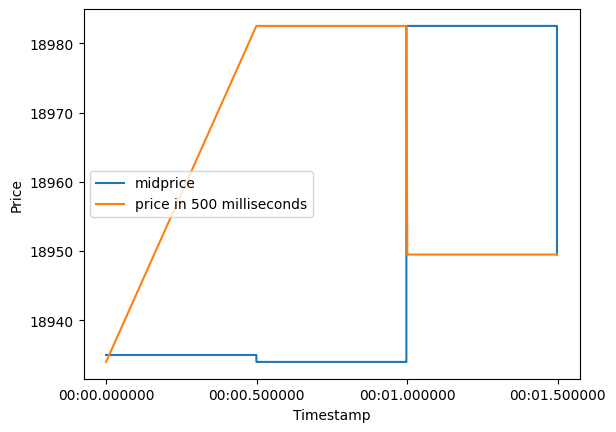

In [5]:
n = 16
_, ax = plt.subplots()
ax.plot(day_df.timestamp[:n], midprice[:n], label='midprice')
ax.plot(day_df.timestamp[:n], future_price[:n], label='price in 500 milliseconds')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Price')
ax.legend()
plt.show()

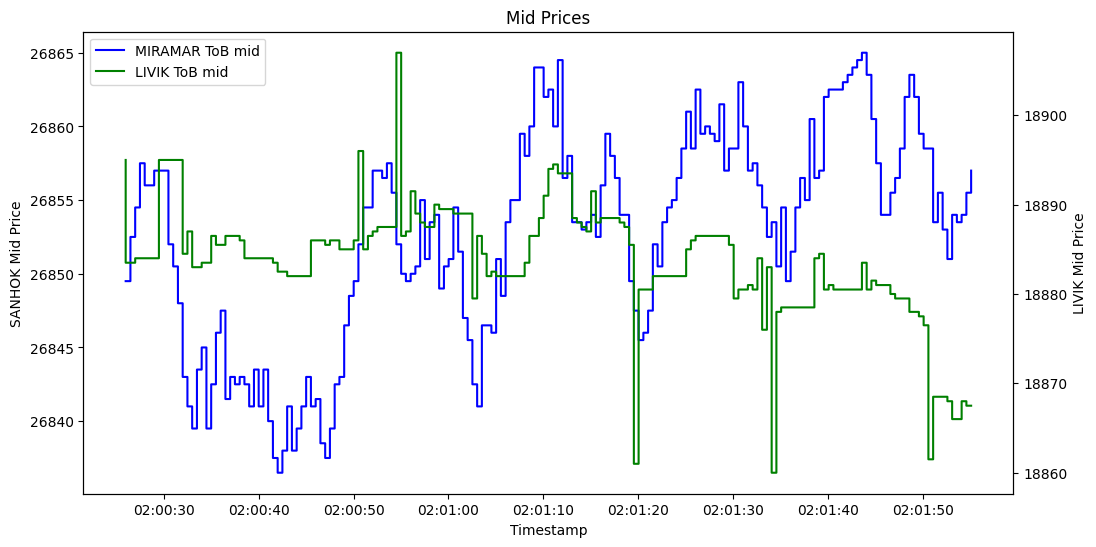

In [6]:
data = df.set_index("timestamp")
instruments = ["MIRAMAR", "LIVIK", "SANHOK", "ERANGEL", "VIKENDI", "KARAKIN"]
for i in instruments:
    data[i + "_ToB_mid"] = (data[i + "_bid0_price"] + data[i + "_ask0_price"]) / 2
    
# plot the bid and ask prices over time
ind1 = 300
ind2 = 1300
instrument1 = "MIRAMAR"
instrument2 = "LIVIK"
# create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# plot the bid and ask prices for the first instrument
ax1.plot(data[ind1:ind2].index, data[ind1:ind2][instrument1 + '_ToB_mid'], label= instrument1 +' ToB mid', color='blue')
# ax1.plot(data[ind1:ind2].index, data[ind1:ind2]['MIRAMAR_ask0_price'], label='MIRAMAR Ask', color='blue')

# plot the bid and ask prices for the second instrument on the right y-axis
ax2.plot(data[ind1:ind2].index, data[ind1:ind2][instrument2 + '_ToB_mid'], label=instrument2 + ' ToB mid', color='green')
# ax2.plot(data[ind1:ind2].index, data[ind1:ind2]['LIVIK_ask0_price'], label='LIVIK Ask', color='green')

# set the labels and title
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('SANHOK Mid Price')
ax2.set_ylabel('LIVIK Mid Price')
plt.title('Mid Prices')

# add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# display the plot
plt.show()

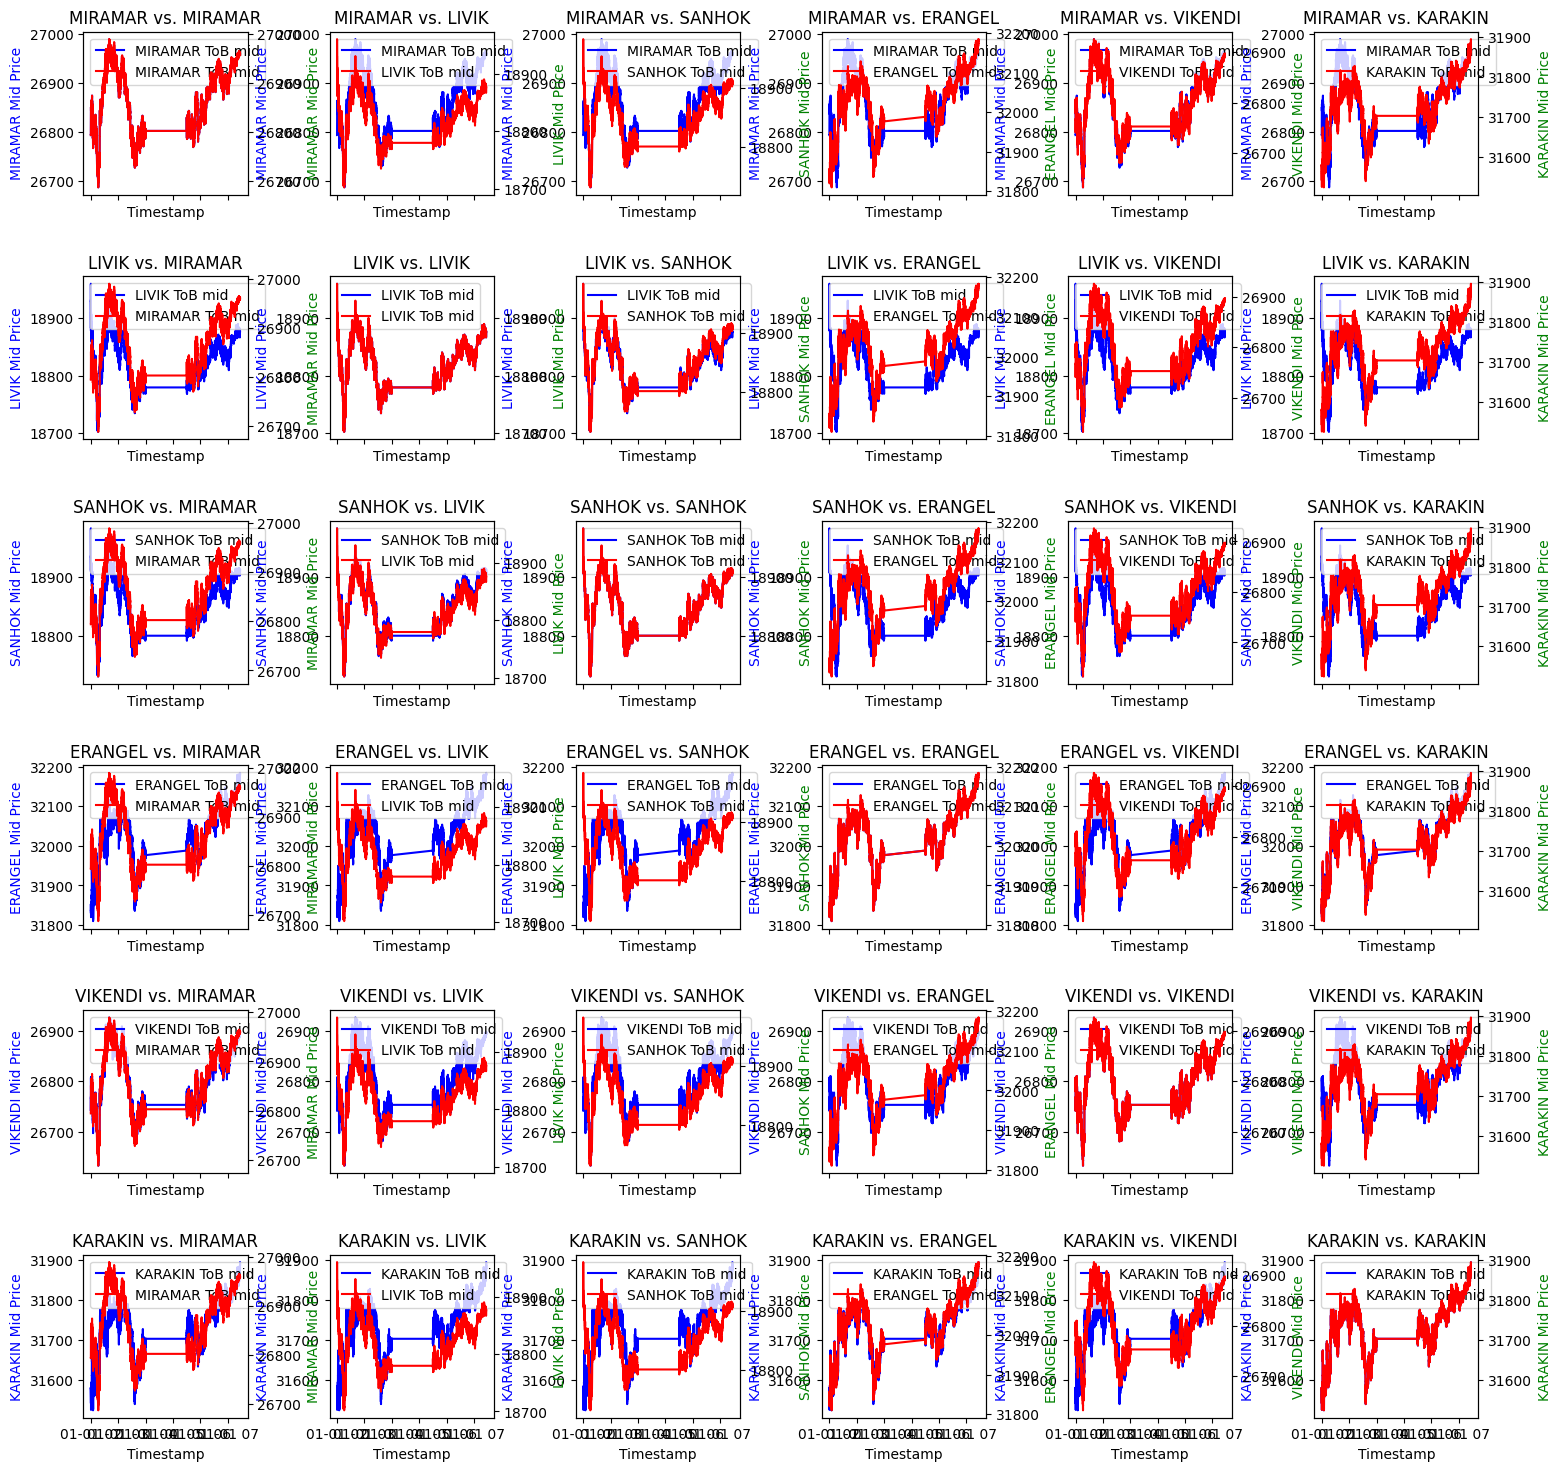

In [7]:
# create a figure with subplots
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(18, 18), sharex=True)
ind1 = 0
ind2 = -1

for i, instrument1 in enumerate(instruments):
    for j, instrument2 in enumerate(instruments):
        # create a twin y-axis for the second instrument
        ax2 = axs[i][j].twinx()
        # plot the bid and ask prices for the first instrument
        axs[i][j].plot(data[ind1:ind2].index, data[ind1:ind2][instrument1 + '_ToB_mid'], label= instrument1 +' ToB mid', color='blue')
        # plot the bid and ask prices for the second instrument on the right y-axis
        ax2.plot(data[ind1:ind2].index, data[ind1:ind2][instrument2 + '_ToB_mid'], label=instrument2 + ' ToB mid', color='red')
        # set the labels and title
        axs[i][j].set_xlabel('Timestamp')
        axs[i][j].set_ylabel(instrument1 + ' Mid Price', color='blue')
        ax2.set_ylabel(instrument2 + ' Mid Price', color='green')
        axs[i][j].set_title(instrument1 + ' vs. ' + instrument2)
        # add a legend
        lines, labels = axs[i][j].get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        axs[i][j].legend(lines + lines2, labels + labels2, loc='upper left')

# adjust the space between the subplots and display the plot
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()


Estimated delay: 0 or ~ 0 days 00:00:00 seconds


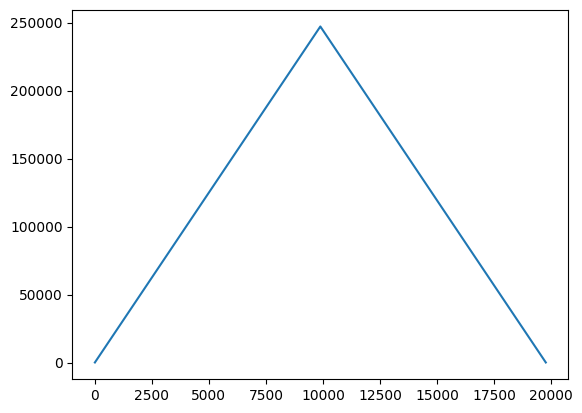

In [24]:
temp_data = data[["SANHOK_ToB_mid", "LIVIK_ToB_mid"]]
temp_data = temp_data.drop_duplicates()
temp_data1 = np.log(temp_data[["SANHOK_ToB_mid"]]).diff().dropna() + 5
temp_data2 = np.log(temp_data[["LIVIK_ToB_mid"]]).diff().dropna() + 5

corr1 = signal.correlate(temp_data1, temp_data2 , mode='full')

plt.plot(corr1)
delay = (np.argmax(corr1) - len(temp_data1['SANHOK_ToB_mid']) + 1)
print("Estimated delay: " + str(delay) +" or ~ " + str(temp_data1.index[abs(delay)]-temp_data1.index[0]) + " seconds")


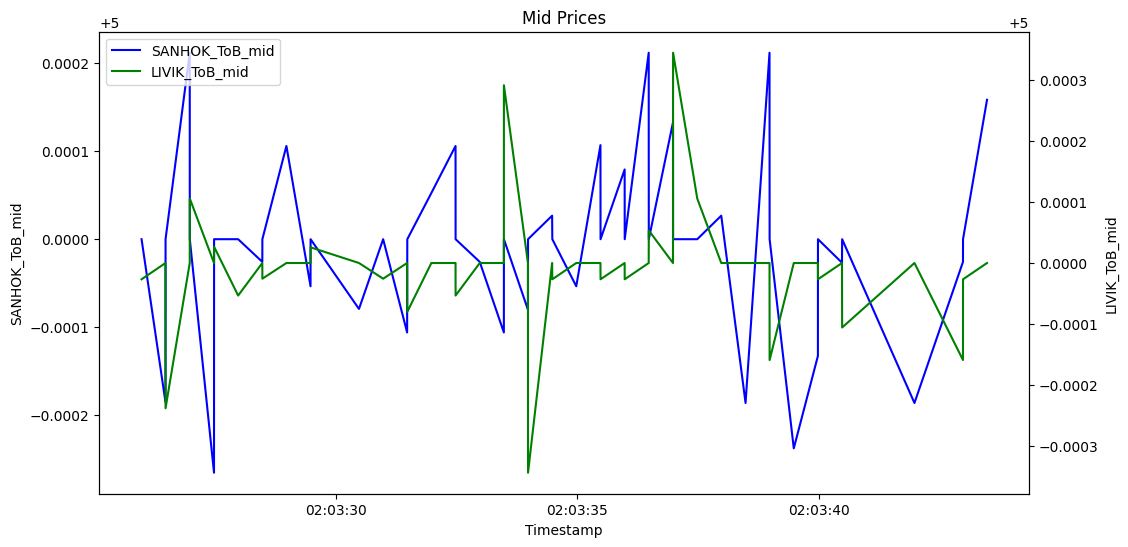

In [25]:
ind1=500
ind2=ind1 + 50
# create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# plot the bid and ask prices for the first instrument
ax1.plot(temp_data1[ind1:ind2].index, temp_data1[ind1:ind2], label= "SANHOK_ToB_mid", color='blue')

# plot the bid and ask prices for the second instrument on the right y-axis
ax2.plot(temp_data2[ind1:ind2].index, temp_data2[ind1:ind2], label="LIVIK_ToB_mid", color='green')

# set the labels and title
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('SANHOK_ToB_mid')
ax2.set_ylabel('LIVIK_ToB_mid')
plt.title('Mid Prices')

# add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# display the plot
plt.show()

Estimated delay of MIRAMAR and MIRAMAR: 0 or ~ 0 days 00:00:00 seconds
Estimated delay of MIRAMAR and LIVIK: 0 or ~ 0 days 00:00:00 seconds
Estimated delay of MIRAMAR and SANHOK: 0 or ~ 0 days 00:00:00 seconds
Estimated delay of MIRAMAR and ERANGEL: 0 or ~ 0 days 00:00:00 seconds
Estimated delay of MIRAMAR and VIKENDI: 0 or ~ 0 days 00:00:00 seconds
Estimated delay of MIRAMAR and KARAKIN: 0 or ~ 0 days 00:00:00 seconds
Estimated delay of LIVIK and MIRAMAR: 0 or ~ 0 days 00:00:00 seconds
Estimated delay of LIVIK and LIVIK: 0 or ~ 0 days 00:00:00 seconds
Estimated delay of LIVIK and SANHOK: 0 or ~ 0 days 00:00:00 seconds
Estimated delay of LIVIK and ERANGEL: 0 or ~ 0 days 00:00:00 seconds
Estimated delay of LIVIK and VIKENDI: 0 or ~ 0 days 00:00:00 seconds
Estimated delay of LIVIK and KARAKIN: 0 or ~ 0 days 00:00:00 seconds
Estimated delay of SANHOK and MIRAMAR: 0 or ~ 0 days 00:00:00 seconds
Estimated delay of SANHOK and LIVIK: 0 or ~ 0 days 00:00:00 seconds
Estimated delay of SANHOK an

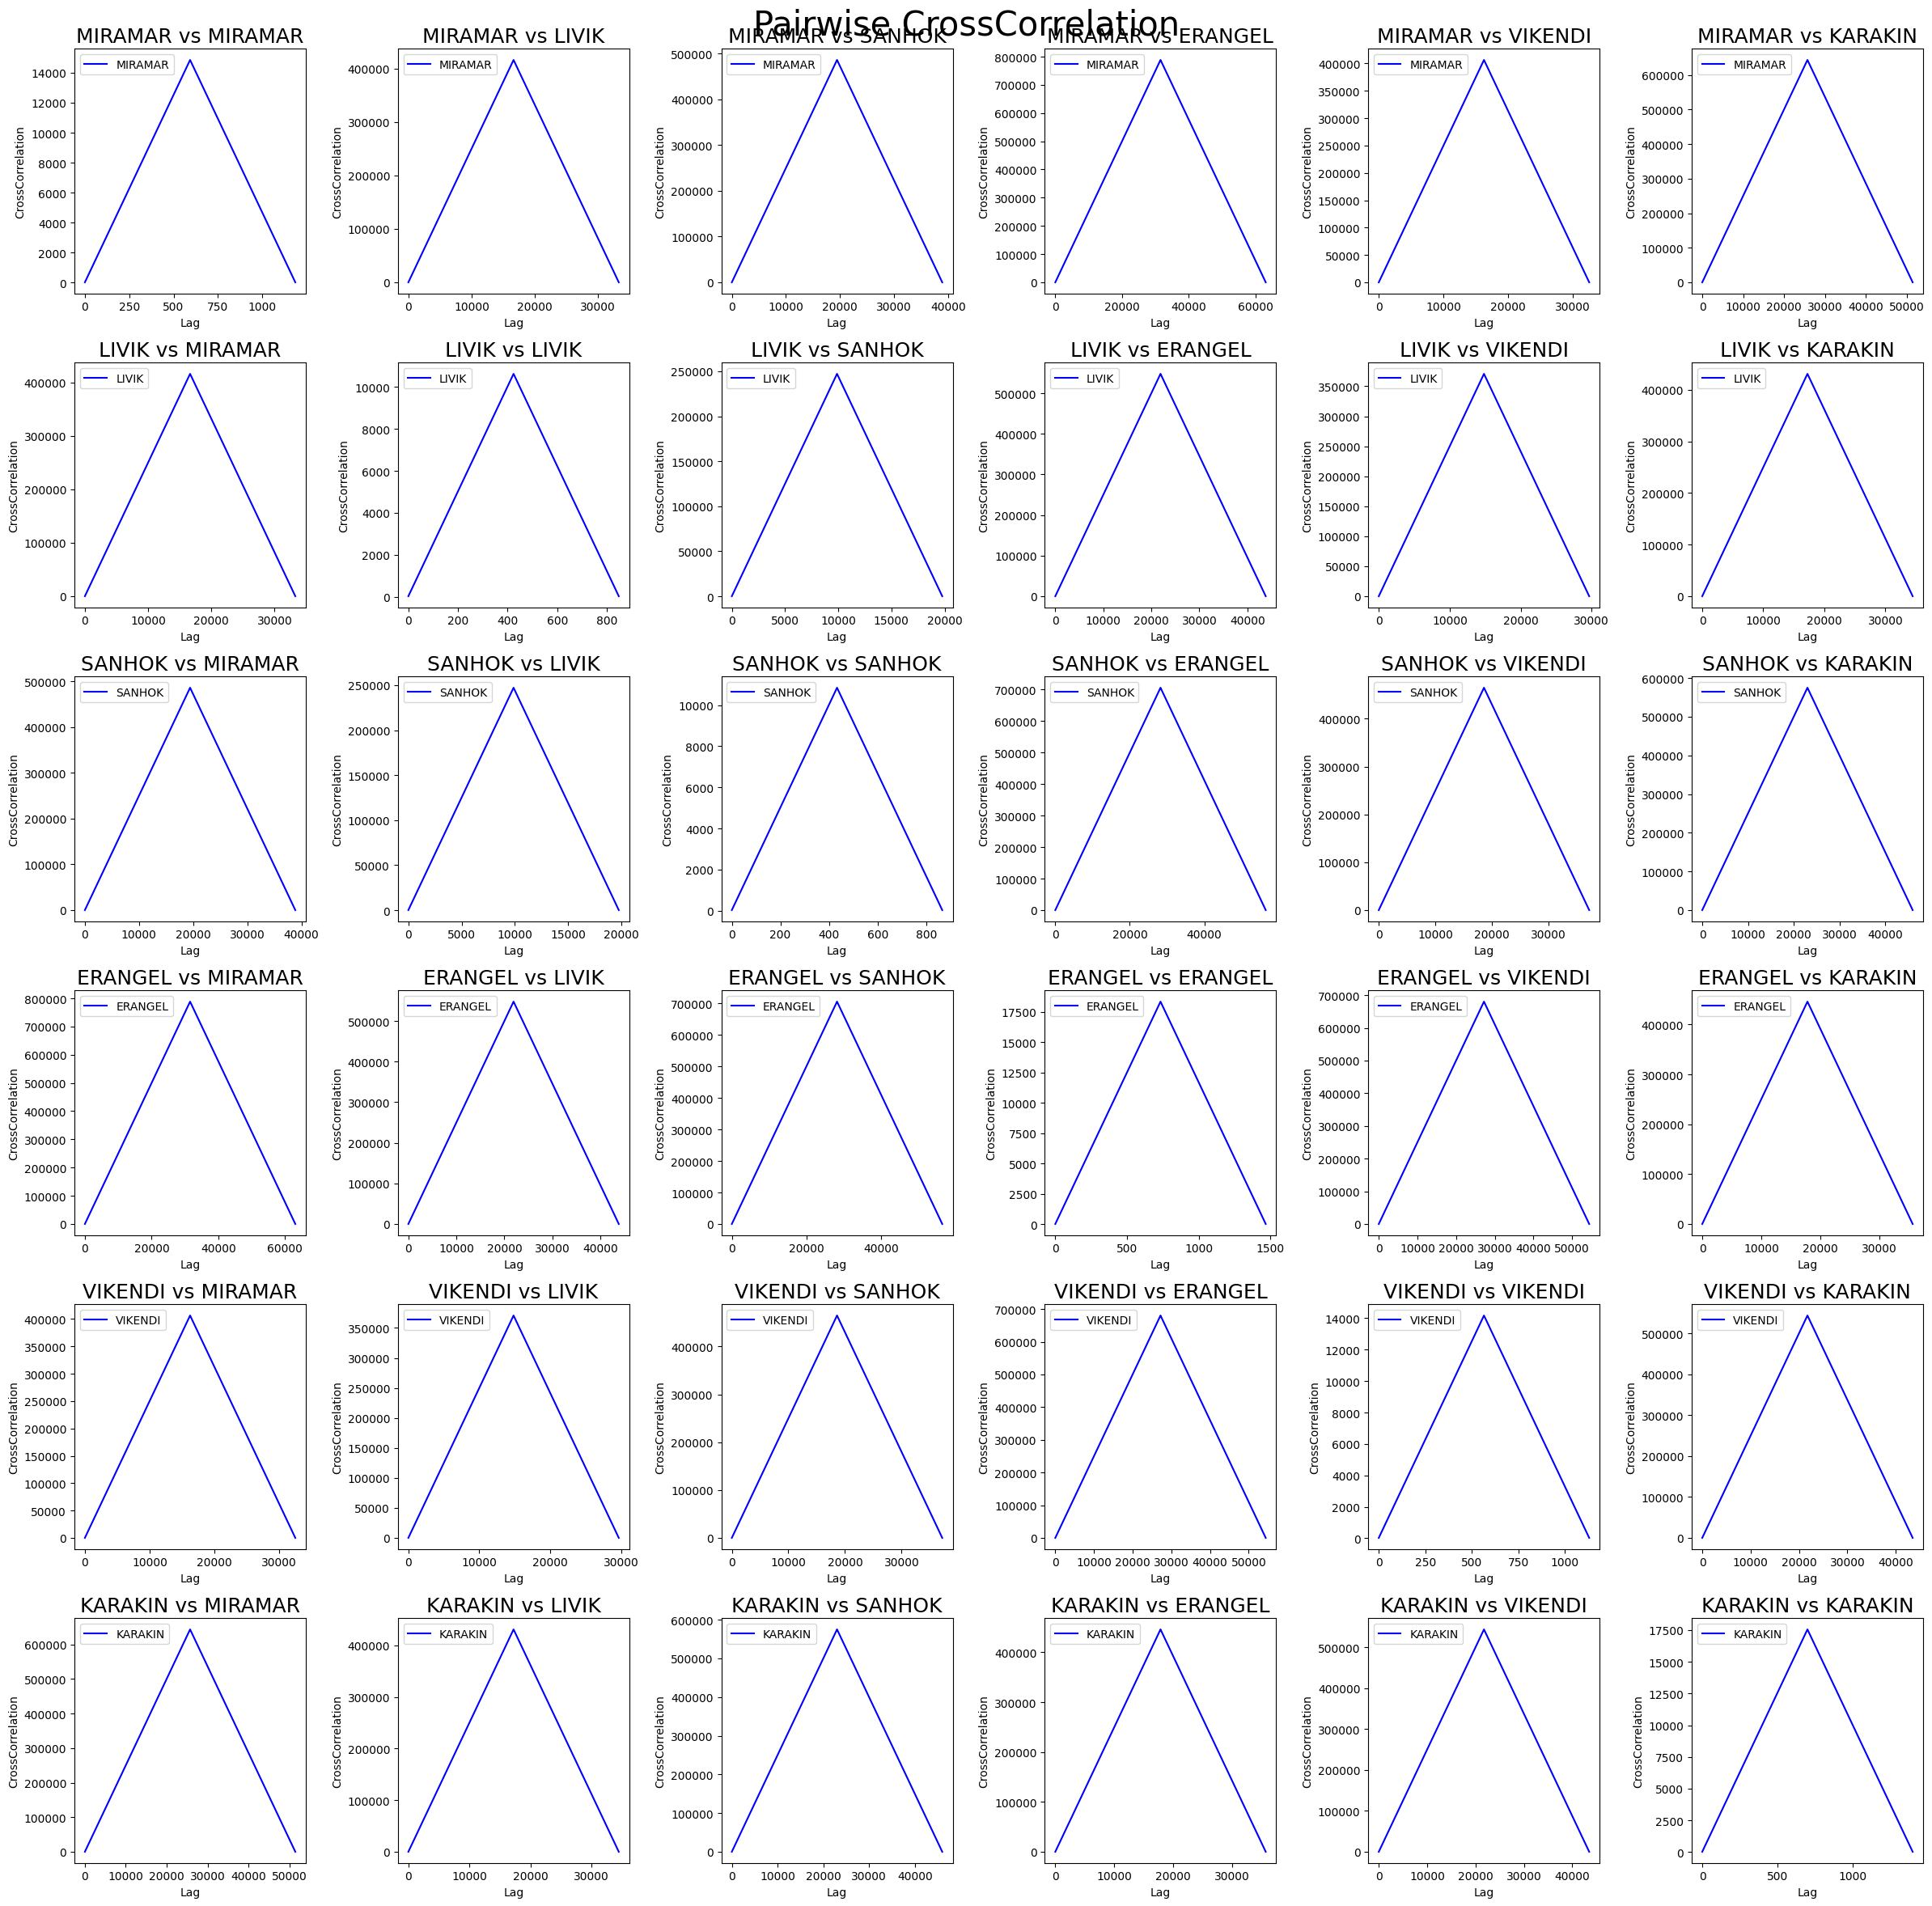

In [23]:
import itertools
# Create a figure with subplots for each pairwise combination of instruments
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(24, 24))
fig.suptitle('Pairwise CrossCorrelation', fontsize=30)

# Loop over all pairwise combinations of instruments and plot the mid prices
for i, j in itertools.product(instruments, instruments):
    # Compute the index of the current subplot
    row_index = instruments.index(i)
    col_index = instruments.index(j)
    if (i == j):
        temp_data = data[[i + '_ToB_mid']]
        temp_data = temp_data.drop_duplicates()
    else:
        temp_data = data[[i + '_ToB_mid', j + '_ToB_mid']]
        temp_data = temp_data.drop_duplicates()

    temp_data1 = np.log(temp_data[[i + '_ToB_mid']]).diff().dropna() + 5
    temp_data2 = np.log(temp_data[[j + '_ToB_mid']]).diff().dropna() + 5

#     print(temp_data1.head(5))
    corr = signal.correlate(temp_data1, temp_data2, mode='full')
    delay = (np.argmax(corr) - len(temp_data1) + 1)
    print("Estimated delay of " + i + " and " + j + ": " + str(delay) +" or ~ " + str(temp_data1.index[abs(delay)] - temp_data1.index[0]) + " seconds")
    # Plot the mid prices for the current pair of instruments
    axs[row_index, col_index].plot(range(len(corr)), corr, label=i, color='blue')
    axs[row_index, col_index].set_title(i + " vs " + j, fontsize=18)
    axs[row_index, col_index].set_xlabel("Lag")
    axs[row_index, col_index].set_ylabel("CrossCorrelation")

    # Add a legend to the plot
    axs[row_index, col_index].legend(loc='upper left')

# Adjust the layout of the subplots and display the plot
plt.tight_layout()
plt.show()


In [10]:
len(data)*2

258222